# 6. APRENDIZAJE SUPERVISADO

Contenido:
1. Clasificación y Regresión
2. Pasos del aprendizaje automático supervisado (pipeline)
3. Modelos lineales: regresión lineal, regresión logística y regularización
4. Evaluación y visualizaciones (fronteras de decisión, métricas)

## 1. Clasificación y Regresión — Definición y problema general

En aprendizaje supervisado disponemos de un conjunto de entrenamiento $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$ con $x_i \in \mathbb{R}^d$ y $y_i$ perteneciente a un conjunto de salida $\mathcal{Y}$.

- Si $\mathcal{Y} = \mathbb{R}$ hablamos de *regresión* (predicción de valores continuos).
- Si $\mathcal{Y}$ es un conjunto finito de etiquetas (por ejemplo $\{1,\dots,K\}$) hablamos de *clasificación*.

El objetivo es estimar una función $f:\mathbb{R}^d\to\mathcal{Y}$ que minimice la pérdida esperada
\begin{equation}
R(f) = \mathbb{E}_{(x,y)\sim P}[L(y,f(x))]
\end{equation}

donde $L$ es la función de pérdida apropiada (por ejemplo, pérdida cuadrática para regresión o entropía cruzada para clasificación).

In [13]:
# Ejemplo rápido: Regresión (Diabetes) y Clasificación (Iris)
from sklearn.datasets import load_diabetes, load_iris
from sklearn.model_selection import train_test_split
import numpy as np

diabetes = load_diabetes()
X_diab, y_diab = diabetes.data, diabetes.target
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_diab, y_diab, test_size=0.2, random_state=0)

iris = load_iris()
X_iris, y_iris = iris.data, iris.target
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_iris, y_iris, test_size=0.2, random_state=0)

print('Shapes: Diabetes', X_train_d.shape, X_test_d.shape, 'Iris', X_train_i.shape, X_test_i.shape)

Shapes: Diabetes (353, 10) (89, 10) Iris (120, 4) (30, 4)


## 2. Pasos del aprendizaje supervisado (pipeline)

Flujo típico:
1. Recolección y comprensión de datos.
2. Limpieza y preprocesamiento (imputación, codificación, escalado).
3. División en conjuntos: entrenamiento, validación y prueba.
4. Selección de modelo y función de pérdida.
5. Entrenamiento y ajuste de hiperparámetros (validación cruzada).
6. Evaluación final y despliegue.

Es importante documentar supuestos y realizar análisis exploratorio previo (EDA).

In [14]:
# Ejemplo: preprocesamiento básico y pipeline simple
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])
scores = cross_val_score(pipeline, X_diab, y_diab, cv=5, scoring='neg_mean_squared_error')
print('CV MSE (neg):', np.round(scores, 4))
print('Mean CV MSE:', np.round(np.mean(scores),4))

CV MSE (neg): [-2787.6292 -3034.9849 -3219.3269 -3005.1066 -2921.1557]
Mean CV MSE: -2993.6407


## 3. Modelos lineales — Regresión Lineal (detalle matemático)

Considere el modelo lineal: $y = X\beta + \varepsilon$, donde $X\in\mathbb{R}^{n\times p}$ (incluye columna de 1 para intercepto), $\beta\in\mathbb{R}^p$ y $\varepsilon$ ruido con media cero. El estimador OLS se obtiene resolviendo
\begin{equation}
\hat{\beta} = \arg\min_{\beta} \|y - X\beta\|_2^2
\end{equation}
y la solución cerrada es
\begin{equation}
\hat{\beta} = (X^T X)^{-1} X^T y,
\end{equation}
si $X^T X$ es invertible. Las propiedades estadísticas (sesgo, varianza) se derivan bajo supuestos clásicos (ruido gaussiano, homocedasticidad).

In [15]:
# Implementación: regresión lineal con scikit-learn y comparación con solución OLS cerrada
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_d, y_train_d)
y_pred = lr.predict(X_test_d)
print('MSE (sklearn):', round(mean_squared_error(y_test_d, y_pred),4))
print('R2 (sklearn):', round(r2_score(y_test_d, y_pred),4))

# Solución OLS mediante matriz (comprobación numérica)
X_design = np.hstack([np.ones((X_train_d.shape[0],1)), X_train_d])
beta_hat = np.linalg.pinv(X_design.T.dot(X_design)).dot(X_design.T).dot(y_train_d)
print('Primeros coeficientes OLS (incluye intercept):', np.round(beta_hat[:5],4))

MSE (sklearn): 3424.2593
R2 (sklearn): 0.3322
Primeros coeficientes OLS (incluye intercept): [ 152.538   -35.5503 -243.1651  562.7623  305.4635]


### 3.1 Regularización (Ridge y Lasso) — motivación

Para evitar sobreajuste cuando $p$ es grande o existe multicolinealidad, añadimos penalizaciones. Ridge (L2) resuelve
\begin{equation}
\hat{\beta}^{\text{Ridge}} = \arg\min_{\beta} \|y - X\beta\|_2^2 + \lambda \|\beta\|_2^2,
\end{equation}
mientras que Lasso (L1) minimiza
\begin{equation}
\hat{\beta}^{\text{Lasso}} = \arg\min_{\beta} \|y - X\beta\|_2^2 + \lambda \|\beta\|_1.
\end{equation}
La regularización controla el sesgo-varianza mediante $\lambda\ge 0$.

In [16]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1, max_iter=10000)
ridge.fit(X_train_d, y_train_d)
lasso.fit(X_train_d, y_train_d)
print('Ridge R2:', round(ridge.score(X_test_d, y_test_d),4))
print('Lasso R2:', round(lasso.score(X_test_d, y_test_d),4))

Ridge R2: 0.341
Lasso R2: 0.3402


## 4. Regresión logística (clasificación binaria) — formulación

La regresión logística modela la probabilidad de la clase positiva mediante la función sigmoide. Para una sola observación $x$:
\begin{equation}
P(y=1|x) = \sigma(w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}.
\end{equation}
El aprendizaje se efectúa minimizando la pérdida (negativa log-verosimilitud):
\begin{equation}
\mathcal{L}(w,b) = -\sum_{i=1}^n \left[y_i \log p_i + (1-y_i)\log(1-p_i)\right],
\end{equation}
con $p_i = P(y_i=1|x_i)$.

In [17]:
# Ejemplo regresión logística (Iris: convertimos a problema binario)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Usamos solo dos clases (setosa vs no-setosa) para ejemplo binario
y_bin = (y_iris == 0).astype(int)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_iris, y_bin, test_size=0.2, random_state=0)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_b, y_train_b)
y_pred_b = logreg.predict(X_test_b)
print(classification_report(y_test_b, y_pred_b))
print('Confusion matrix:')
print(confusion_matrix(y_test_b, y_pred_b))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion matrix:
[[19  0]
 [ 0 11]]


## 5. Visualización: frontera de decisión y curva de regresión

Visualizar fronteras de decisión ayuda a comprender modelos en baja dimensión. Para modelos lineales en 2D la frontera es el hiperplano $w^T x + b = 0$.

Para regresión, se visualiza el ajuste y el intervalo de predicción (si procede).

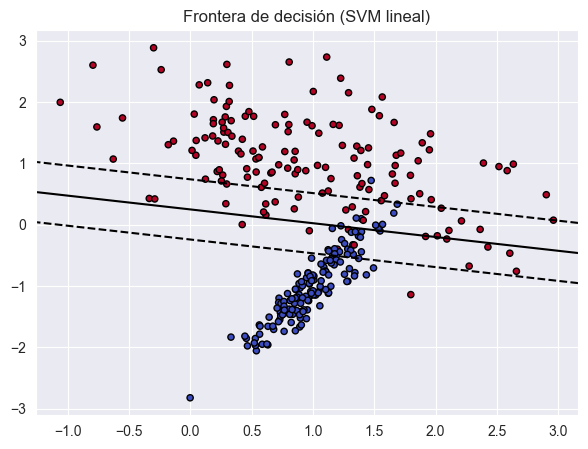

In [18]:
# Visualización de frontera de decisión para SVM lineal (datos sintéticos 2D)
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X2, y2 = make_classification(n_samples=300, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
Xtr, Xte, ytr, yte = train_test_split(X2, y2, test_size=0.3, random_state=42)
svc = SVC(kernel='linear').fit(Xtr, ytr)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='coolwarm', s=20, edgecolor='k')
ax = plt.gca()
xlim = ax.get_xlim(); ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 200)
yy = np.linspace(ylim[0], ylim[1], 200)
YY, XX = np.meshgrid(yy, xx)
grid = np.c_[XX.ravel(), YY.ravel()]
Z = svc.decision_function(grid).reshape(XX.shape)
ax.contour(XX, YY, Z, levels=[-1,0,1], linestyles=['--','-','--'], colors='k')
plt.title('Frontera de decisión (SVM lineal)')
plt.show()

## 6. Evaluación: métricas y validación

### Regresión:
- $\text{MSE} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2$ (Error cuadrático medio)
- $R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$

### Clasificación:
- Accuracy, Precision, Recall, F1-score.
- ROC y AUC para problemas binarios.

Se recomienda siempre usar validación cruzada para estimaciones robustas del desempeño.

In [19]:
# Ejemplo: evaluación con validación cruzada en clasificación (Iris multiclass)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier(n_estimators=100, random_state=0)
scores_acc = cross_val_score(rf, X_iris, y_iris, cv=5, scoring='accuracy')
scores_f1 = cross_val_score(rf, X_iris, y_iris, cv=5, scoring=make_scorer(f1_score, average='macro'))
print('CV Accuracy:', np.round(scores_acc,4))
print('Mean Accuracy:', np.round(np.mean(scores_acc),4))
print('CV F1-macro:', np.round(scores_f1,4))

CV Accuracy: [0.9667 0.9667 0.9333 0.9667 1.    ]
Mean Accuracy: 0.9667
CV F1-macro: [0.9666 0.9666 0.9327 0.9666 1.    ]


## 7. Notas prácticas y recomendaciones docentes

- Normalizar o estandarizar las features cuando los modelos lo requieran (SVM, KNN, regresión regularizada).
- Usar curvas de validación para ajustar hiperparámetros y evitar sobreajuste.
- Evaluar el impacto de variables con técnicas de interpretabilidad (coeficientes para modelos lineales, SHAP/feature importance para modelos complejos).
- Documentar supuestos (normalidad, homocedasticidad) cuando se empleen inferencias estadísticas sobre coeficientes.

### Referencias
- Hastie, T., Tibshirani, R., Friedman, J. (2009). *The Elements of Statistical Learning*.
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*.
- Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn & TensorFlow*.